In [27]:
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# カレントディレクトリの移動・確認
%cd drive/MyDrive/cnn_visualization_workspace
!pwd

[Errno 2] No such file or directory: 'drive/MyDrive/cnn_visualization_workspace'
/content/drive/MyDrive/cnn_visualization_workspace
/content/drive/My Drive/cnn_visualization_workspace


In [29]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

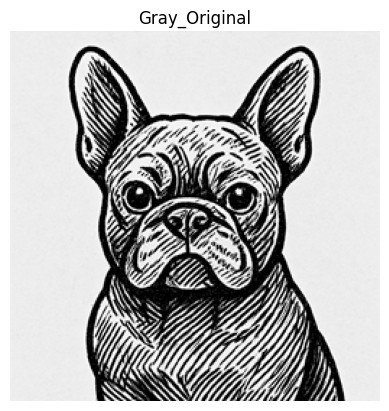

In [30]:
# 画像読み込み（グレースケール）
img_gray = cv2.imread("data/input/inu_grayscale_256.jpg", cv2.IMREAD_GRAYSCALE)

# 表示
plt.imshow(img_gray, cmap='gray')
plt.title("Gray_Original")
plt.axis("off")
plt.show()

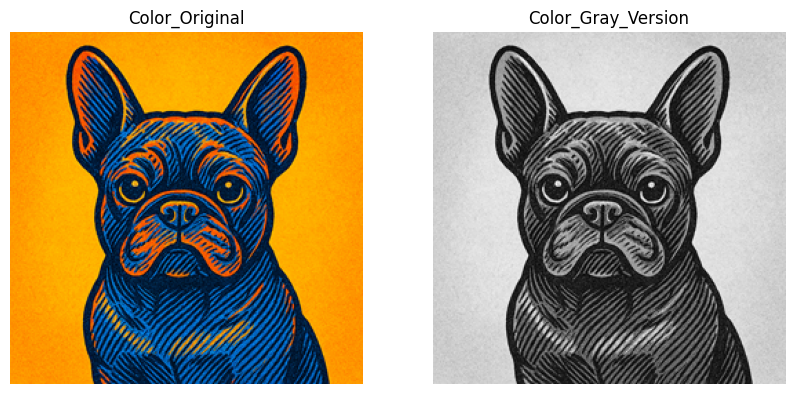

In [31]:
# 画像読み込み（カラー）
img_color = cv2.imread("data/input/inu_color_256.jpg", cv2.IMREAD_COLOR)
# BGR → RGB に変換（matplotlib表示にも使える）
img_color_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
img_color_rgb_gray = cv2.cvtColor(img_color_rgb, cv2.COLOR_RGB2GRAY)

# 表示
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# オリジナルカラー画像
axs[0].imshow(img_color_rgb)
axs[0].set_title("Color_Original")
axs[0].axis("off")
# オリジナルカラー画像をグレースケール化した画像
axs[1].imshow(img_color_rgb_gray, cmap='gray')
axs[1].set_title("Color_Gray_Version")
axs[1].axis("off")
plt.show()

In [32]:
# 1.自作カーネルでの畳み込みをして可視化する
# -----------------------------------------
# 自作カーネルの定義
kernels = {
    # 左から右へ縦のエッジを強調させる
    "Vertical_Edge": np.array([[ -1, 0, 1],
                               [ -2, 0, 2],
                               [ -1, 0, 1]]),
    # 上から下へ横のエッジを強調させる
    "Horizontal_Edge": np.array([[ -1, -2, -1],
                                 [  0,  0,  0],
                                 [  1,  2,  1]]),
    # 左下から右上へ斜めのエッジを強調させる
    "Diagonal_Edge": np.array([[ 0,  1,  2],
                                [-1,  0,  1],
                                [-2, -1,  0]])
}
no_kernel = np.zeros((300,300))

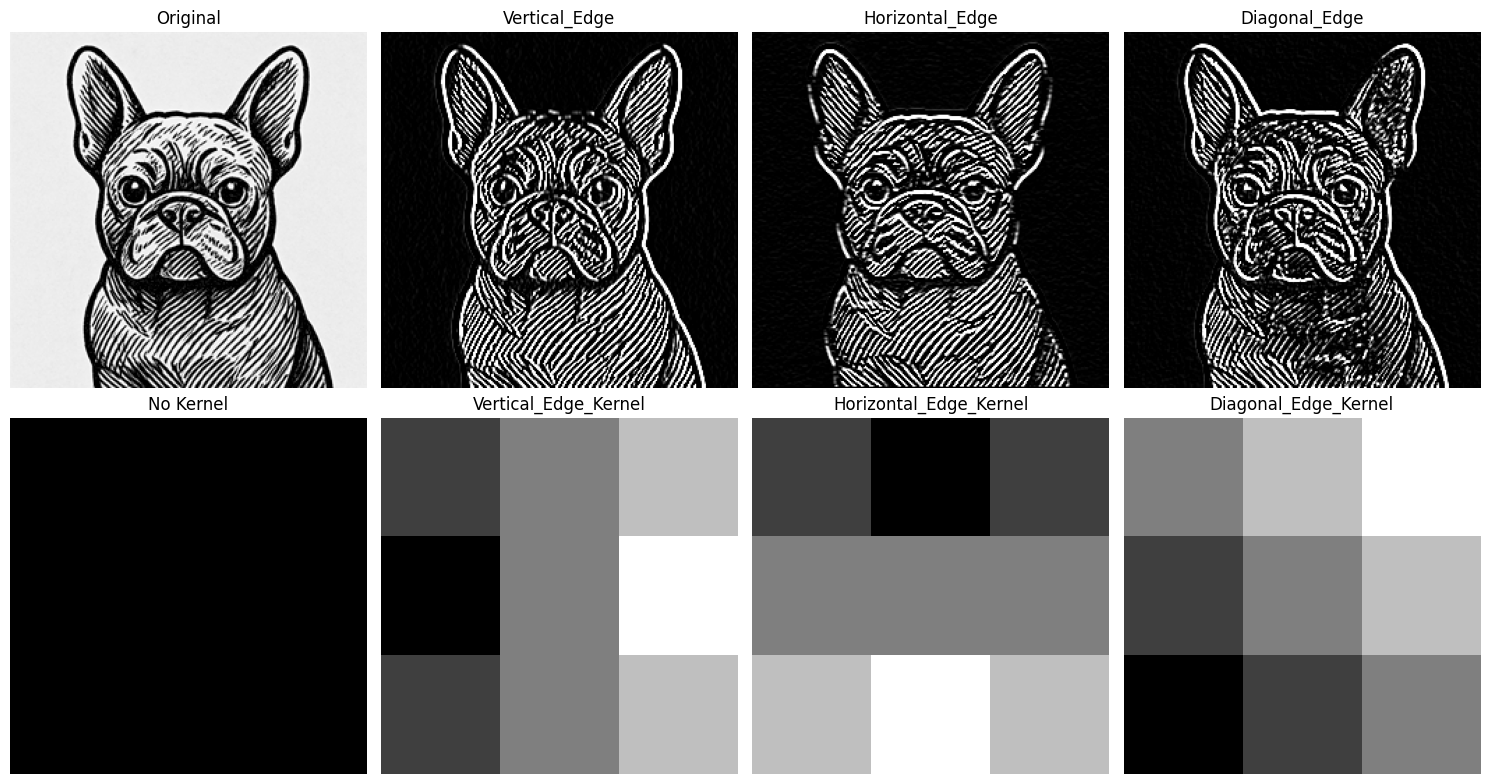

In [33]:
# 畳み込みと表示（グレー）
fig, axs = plt.subplots(2, len(kernels)+1, figsize=(15, 8))
axs[0, 0].imshow(img_gray, cmap='gray')
axs[0, 0].set_title("Original")
axs[0, 0].axis("off")
axs[1, 0].imshow(no_kernel,cmap='gray')
axs[1, 0].set_title("No Kernel")
axs[1, 0].axis("off")

for i, (name, kernel) in enumerate(kernels.items(), start=1):
    output = cv2.filter2D(img_gray, -1, kernel)
    axs[0, i].imshow(output, cmap='gray')
    axs[0, i].set_title(name)
    axs[0, i].axis("off")
    # カーネルを保存するために正規化（0〜255）
    kernel_norm = (kernel - kernel.min()) / (kernel.max() - kernel.min()) * 255
    kernel_uint8 = kernel_norm.astype(np.uint8)
    axs[1, i].imshow(kernel_uint8, cmap='gray')
    axs[1, i].set_title(f"{name}_Kernel")
    axs[1, i].axis("off")
    # 保存
    my_kernel_enlarged = cv2.resize(kernel_uint8, (300, 300), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(f"data/kernels/self_made/my_kernel_ {name}.png", my_kernel_enlarged) # カーネル
    cv2.imwrite(f"data/outputs/feature_map/self_made_filters/{i}_feature_map_my_kernel_{name}_gray.png", output) # 画像

plt.tight_layout()
plt.show()

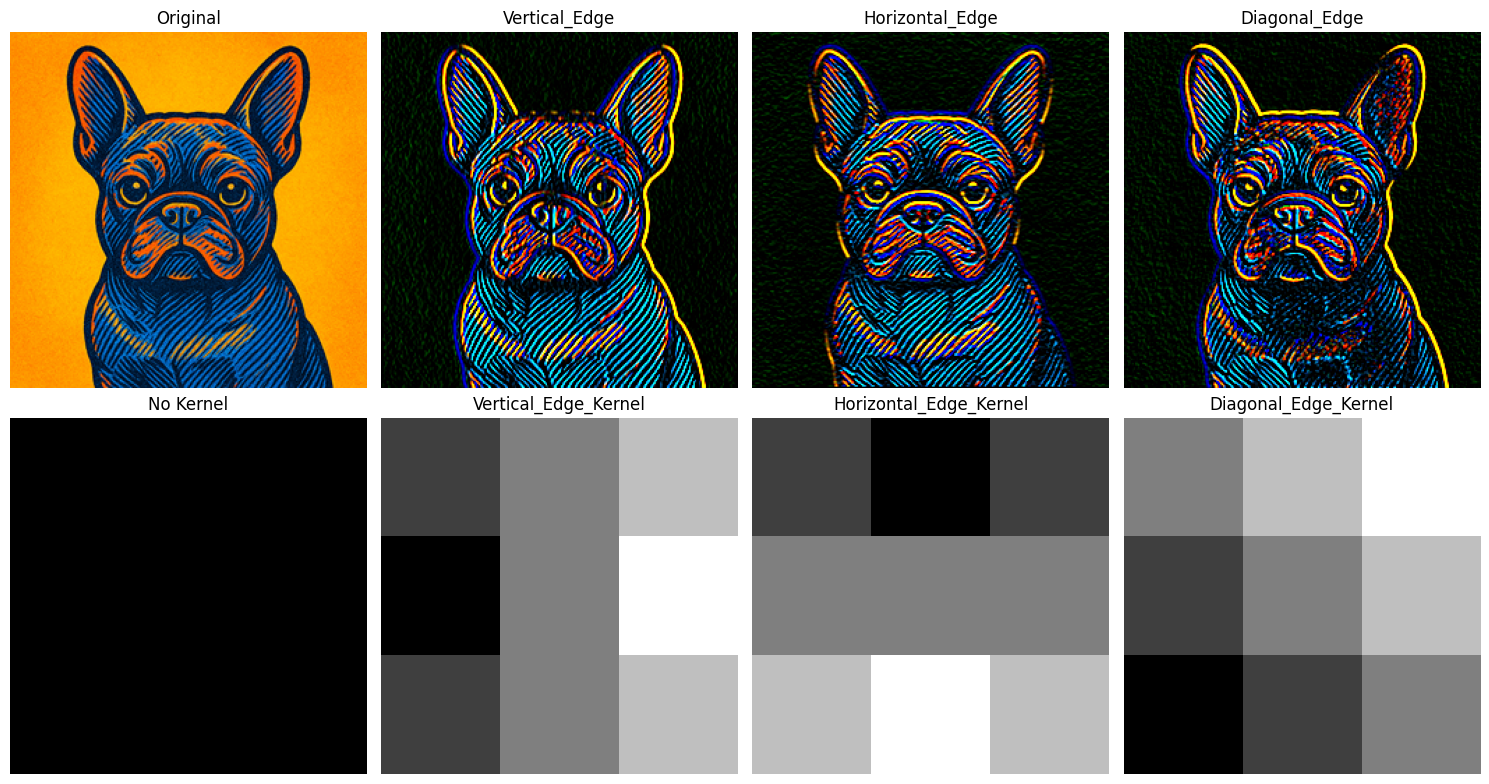

In [34]:
# 畳み込みと表示（カラー）
fig, axs = plt.subplots(2, len(kernels)+1, figsize=(15, 8))
axs[0, 0].imshow(img_color_rgb)
axs[0, 0].set_title("Original")
axs[0, 0].axis("off")
axs[1, 0].imshow(no_kernel,cmap='gray')
axs[1, 0].set_title("No Kernel")
axs[1, 0].axis("off")

for i, (name, kernel) in enumerate(kernels.items(), start=1):
    output = cv2.filter2D(img_color_rgb, -1, kernel)
    axs[0, i].imshow(output)
    axs[0, i].set_title(name)
    axs[0, i].axis("off")
    # カーネルを保存するために正規化（0〜255）
    kernel_norm = (kernel - kernel.min()) / (kernel.max() - kernel.min()) * 255
    kernel_uint8 = kernel_norm.astype(np.uint8)
    axs[1, i].imshow(kernel_uint8, cmap='gray')
    axs[1, i].set_title(f"{name}_Kernel")
    axs[1, i].axis("off")
    # 保存
    # cv2.imwrite(f"data/kernels/self_made/my_kernel_{name}.png", kernel_uint8) # カーネル
    cv2.imwrite(f"data/outputs/feature_map/self_made_filters/{i}_feature_map_my_kernel_{name}_color.png", output) # 画像


plt.tight_layout()
plt.show()

In [35]:
# 2.TensorFlowの自動で生成されるカーネルでの畳み込みをして可視化する
# -----------------------------------------
# 入力を (1, 256, 256, 1) に変形してTensorに
img_tensor = tf.convert_to_tensor(img_gray.reshape(1, 256, 256, 1), dtype=tf.float32)

# Conv2D層の作成（3x3カーネル, 4フィルタ）
conv_layer = tf.keras.layers.Conv2D(filters=4, kernel_size=3, padding='same', use_bias=False)

# 畳み込み適用
output_tensor = conv_layer(img_tensor)

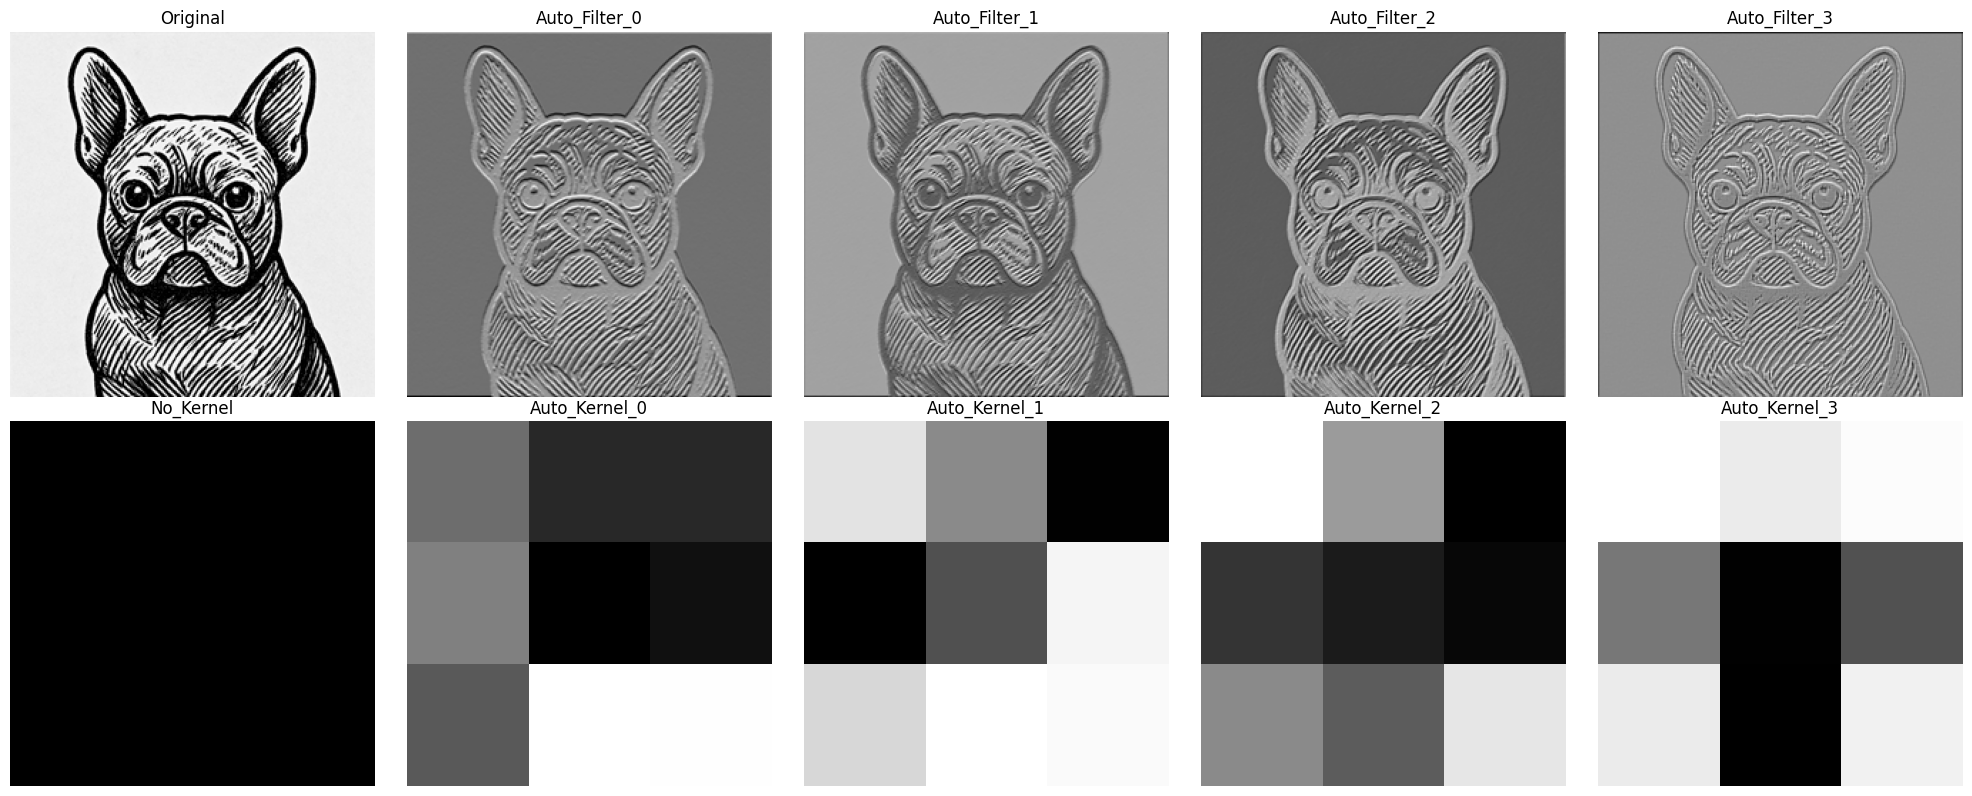

In [36]:
# カーネルの中身（重み）を取得
kernels_learned = conv_layer.get_weights()[0]  # shape: (3, 3, 1, 4)

# 出力特徴マップ（1枚の画像分）
output_maps = output_tensor[0].numpy()  # shape: (32, 32, 4)

# 可視化
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs[0, 0].imshow(img_gray, cmap='gray')
axs[0, 0].set_title("Original")
axs[0, 0].axis("off")
axs[1, 0].imshow(no_kernel,cmap='gray')
axs[1, 0].set_title("No_Kernel")
axs[1, 0].axis("off")

for i in range(4):
    feature_map = output_maps[:, :, i]
    axs[0, i+1].imshow(feature_map, cmap='gray')
    axs[0, i+1].set_title(f"Auto_Filter_{i}")
    axs[0, i+1].axis("off")
    # カーネルを保存するためにTensorFlowのカーネル → NumPyに変換＆逆正規化（0〜255）
    tf_kernel = kernels_learned[...,i]
    kernel_array = tf_kernel.squeeze()
    kernel_norm = (kernel_array - kernel_array.min()) / (kernel_array.max() - kernel_array.min()) * 255
    kernel_uint8 = kernel_norm.astype(np.uint8)
    axs[1, i+1].imshow(kernel_uint8,cmap='gray')
    axs[1, i+1].set_title(f"Auto_Kernel_{i}")
    axs[1, i+1].axis("off")
    # 最小値と最大値に基づいてスケーリング（逆正規化）（0〜255）
    feature_map_norm = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min()) * 255
    gray_img_uint8 = feature_map_norm.astype(np.uint8)
    # 保存
    kernel_enlarged = cv2.resize(kernel_uint8, (300, 300), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(f"data/kernels/TensorFlow_auto/{i}_auto_kernel_{i}_gray.png", kernel_enlarged) # カーネル
    cv2.imwrite(f"data/outputs/feature_map/TensorFlow_auto_filters/{i}_feature_map_auto_filter_{i}_gray.png", gray_img_uint8) # 画像
    # print(f"Example of learned kernel (filter {i}):")
    # print(np.round(kernels_learned[:, :, 0, i], 2))
    # print(output_maps[:, :, i])
    # print(output_maps[:, :, i].shape)


plt.tight_layout()
plt.show()

In [37]:
# カラー画像はfloat32型に変換して正規化
img_rgb_normalization = img_color_rgb.astype("float32") / 255.0
# 入力を (1, 256, 256, 3) に変形してTensorに
img_tensor = tf.convert_to_tensor(img_rgb_normalization.reshape(1, 256, 256, 3), dtype=tf.float32)

# Conv2D層の作成（3x3カーネル, 4フィルタ）
conv_layer = tf.keras.layers.Conv2D(filters=4, kernel_size=3, padding='same', use_bias=False)

# 畳み込み適用
output_tensor = conv_layer(img_tensor)

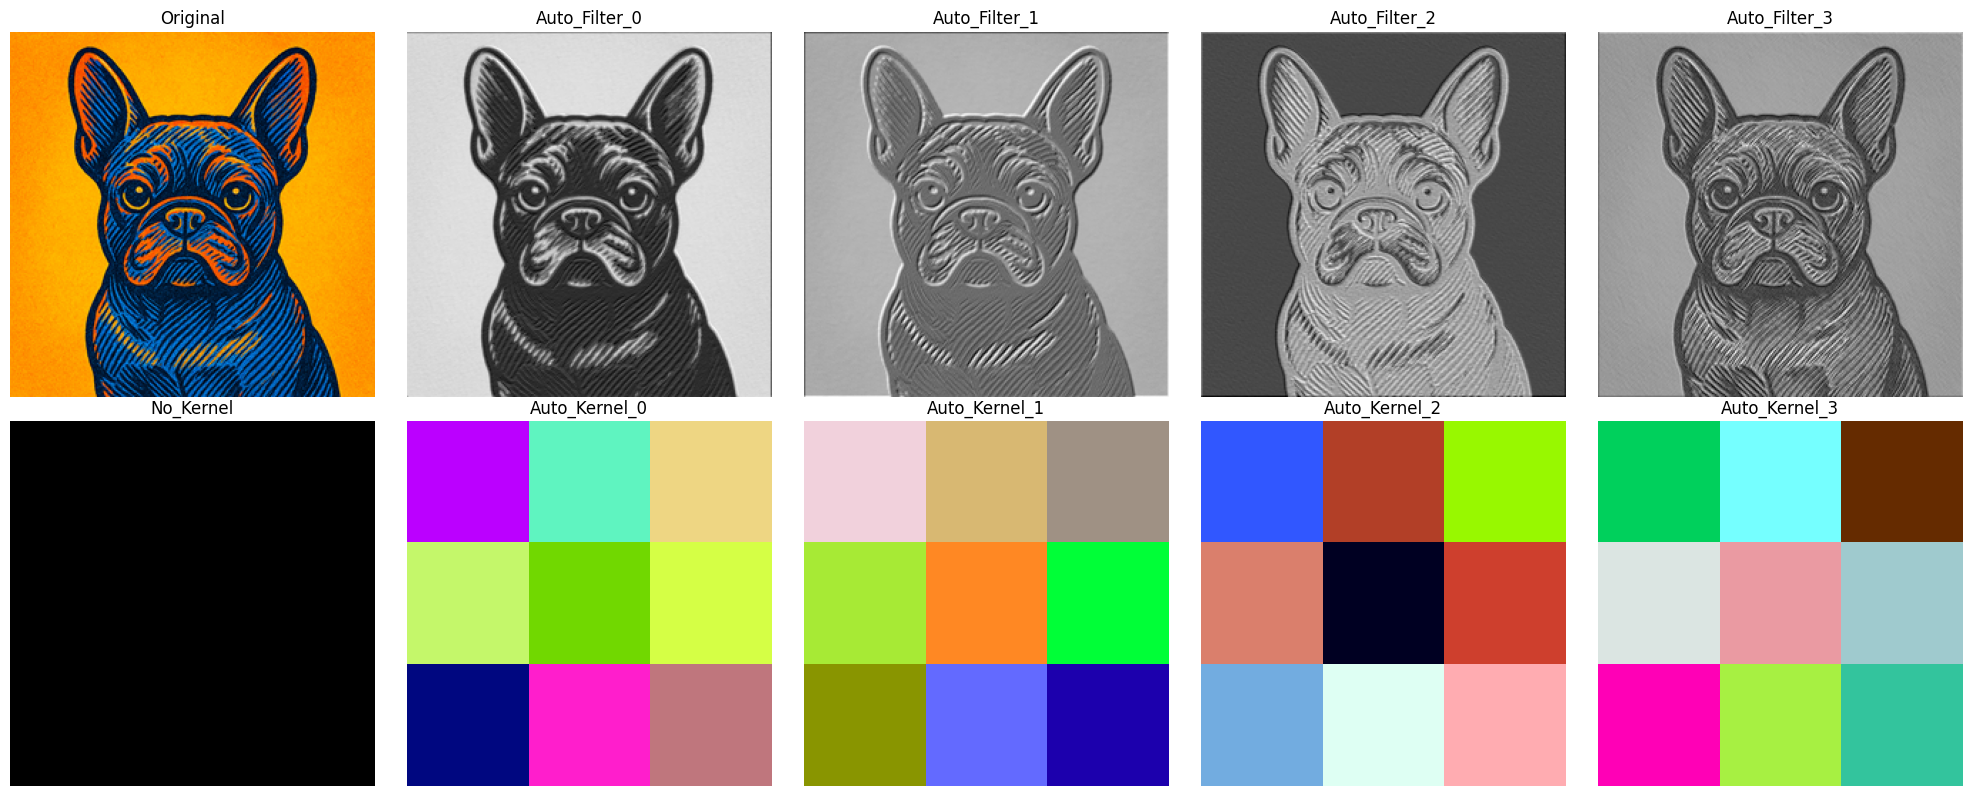

In [38]:
# カーネルの中身（重み）を取得
kernels_learned = conv_layer.get_weights()[0]  # shape: (3, 3, 3, 4)

# 出力特徴マップ（1枚の画像分）
output_maps = output_tensor[0].numpy()  # shape: (32, 32, 4)

# 可視化
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs[0, 0].imshow(img_color_rgb)
axs[0, 0].set_title("Original")
axs[0, 0].axis("off")
axs[1, 0].imshow(no_kernel,cmap='gray')
axs[1, 0].set_title("No_Kernel")
axs[1, 0].axis("off")

for i in range(4):
    feature_map = output_maps[:, :, i]
    axs[0, i+1].imshow(feature_map, cmap='gray')
    axs[0, i+1].set_title(f"Auto_Filter_{i}")
    axs[0, i+1].axis("off")
    # カーネルを保存するためにチャネルごとにカーネル（3ch）の正規化（0〜255）
    tf_kernel = kernels_learned[..., i]  # shape: (3, 3, 3)
    kernel_uint8 = np.zeros_like(tf_kernel)
    for c in range(3):
        k = tf_kernel[..., c]
        k_norm = (k - k.min()) / (k.max() - k.min() + 1e-8) * 255
        kernel_uint8[..., c] = k_norm
    kernel_uint8 = kernel_uint8.astype(np.uint8)
    axs[1, i+1].imshow(kernel_uint8)
    axs[1, i+1].set_title(f"Auto_Kernel_{i}")
    axs[1, i+1].axis("off")
    # 最小値と最大値に基づいてスケーリング（逆正規化）（0〜255）
    feature_map_norm = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min()) * 255
    color_img_uint8 = feature_map_norm.astype(np.uint8)
    # 保存
    kernel_enlarged = cv2.resize(kernel_uint8, (300, 300), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(f"data/kernels/TensorFlow_auto/{i}_auto_kernel_{i}_color.png", kernel_enlarged) # カーネル
    cv2.imwrite(f"data/outputs/feature_map/TensorFlow_auto_filters/{i}_feature_map_auto_filter_{i}_color.png", color_img_uint8) # 画像
    # print(f"Example of learned kernel (filter {i}):")
    # print(np.round(kernels_learned[:, :, 0, i], 2))
    # print(output_maps[:, :, i])
    # print(output_maps[:, :, i].shape)

plt.tight_layout()
plt.show()

In [39]:
diff = np.abs(gray_img_uint8 - color_img_uint8)
print("最大差:", diff.max())

最大差: 255


In [41]:
!pip freeze > requirements.txt